# Сравнение методов рекомендаций (Research)

Ноутбук собирает метрики из `research/results/*.json`, строит таблицу сравнения и графики по `overall / warm / cold / coverage`.

In [1]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)


In [2]:
# Путь к папке с метриками (при необходимости поменяйте)
RESULTS_DIR = Path('../results')
print('RESULTS_DIR =', RESULTS_DIR.resolve())


RESULTS_DIR = /Users/flexonafft/BookRecs/research/results


In [3]:
# Загружаем все *_metrics.json рекурсивно (включая подпапки first/second)
metric_files = sorted(RESULTS_DIR.rglob('*_metrics.json'))
print('Найдено файлов:', len(metric_files))
for p in metric_files:
    print('-', p)


Найдено файлов: 9
- ../results/first/baseline_metrics.json
- ../results/first/content_tfidf_metrics.json
- ../results/first/hybrid_content_popular_metrics.json
- ../results/second/content_tfidf_top500_metrics.json
- ../results/second/hybrid_70_30_metrics.json
- ../results/second/hybrid_70_30_top500_metrics.json
- ../results/third/baseline_metrics.json
- ../results/third/content_tfidf_metrics.json
- ../results/third/hybrid_content_popular_metrics.json


In [4]:
def _load_metrics_json(path: Path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # baseline_metrics.json может быть списком
    if isinstance(data, list):
        rows = data
    else:
        rows = [data]

    for row in rows:
        row.setdefault('source_file', path.name)
        row.setdefault('source_path', str(path.relative_to(RESULTS_DIR)))
        # first / second / third / .
        row.setdefault('run_group', path.parent.name if path.parent != RESULTS_DIR else 'root')
    return rows

rows = []
for p in metric_files:
    rows.extend(_load_metrics_json(p))

metrics_df = pd.DataFrame(rows)

# Приводим числовые колонки
num_cols = [c for c in metrics_df.columns if '@' in c or c.endswith('_users') or c == 'coverage@10']
for c in num_cols:
    metrics_df[c] = pd.to_numeric(metrics_df[c], errors='coerce')

# Удобный порядок колонок
front_cols = [
    'run_group', 'model', 'source_file', 'source_path',
    'ndcg@10', 'recall@10', 'coverage@10',
    'cold_ndcg@10', 'cold_recall@10',
    'warm_ndcg@10', 'warm_recall@10',
    'eval_users', 'cold_eval_users', 'warm_eval_users',
]
front_cols = [c for c in front_cols if c in metrics_df.columns]
other_cols = [c for c in metrics_df.columns if c not in front_cols]
metrics_df = metrics_df[front_cols + other_cols].sort_values(['model', 'run_group', 'source_file']).reset_index(drop=True)
metrics_df



,run_group,model,source_file,source_path,ndcg@10,recall@10,coverage@10,cold_ndcg@10,cold_recall@10,warm_ndcg@10,warm_recall@10,eval_users,cold_eval_users,warm_eval_users,fit_max_features,fit_min_df,candidate_top_n,elapsed_sec,content_weight,popularity_weight,content_top_n,pop_candidates_n
0,first,content_tfidf,content_tfidf_metrics.json,first/content_tfidf_metrics.json,0.006716,0.012226,0.391713,0.006210,0.009721,0.006613,0.012115,46091,1603,45832,50000.0,2.0,200.0,321.74,NaN,NaN,NaN,NaN
1,third,content_tfidf,content_tfidf_metrics.json,third/content_tfidf_metrics.json,0.003670,0.006111,0.440172,0.001635,0.003146,0.003577,0.006032,167105,29399,165750,50000.0,2.0,200.0,1054.34,NaN,NaN,NaN,NaN
2,second,content_tfidf_top500,content_tfidf_top500_metrics.json,second/content_tfidf_top500_metrics.json,0.006717,0.012226,0.391732,0.006210,0.009721,0.006613,0.012115,46091,1603,45832,50000.0,2.0,500.0,339.05,NaN,NaN,NaN,NaN
3,second,hybrid_70_30,hybrid_70_30_metrics.json,second/hybrid_70_30_metrics.json,0.013051,0.026103,0.339330,0.006043,0.009721,0.013007,0.026119,46091,1603,45832,NaN,NaN,NaN,332.49,0.7,0.3,200.0,200.0
4,second,hybrid_70_30_top500,hybrid_70_30_top500_metrics.json,second/hybrid_70_30_top500_metrics.json,0.012472,0.024877,0.346545,0.006024,0.009721,0.012417,0.024852,46091,1603,45832,NaN,NaN,NaN,378.76,0.7,0.3,500.0,300.0
5,first,hybrid_content_popular,hybrid_content_popular_metrics.json,first/hybrid_content_popular_metrics.json,0.010086,0.019939,0.365493,0.006210,0.009721,0.010006,0.019880,46091,1603,45832,NaN,NaN,NaN,330.40,0.8,0.2,200.0,200.0
6,third,hybrid_content_popular,hybrid_content_popular_metrics.json,third/hybrid_content_popular_metrics.json,0.005459,0.009443,0.407081,0.001573,0.003010,0.005388,0.009406,167105,29399,165750,NaN,NaN,NaN,1085.76,0.8,0.2,200.0,200.0
7,first,top_popular,baseline_metrics.json,first/baseline_metrics.json,0.032904,0.047184,0.001091,0.000000,0.000000,0.033159,0.047574,46091,1603,45832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,third,top_popular,baseline_metrics.json,third/baseline_metrics.json,0.043530,0.055929,0.003292,0.000000,0.000000,0.043978,0.056609,167105,29399,165750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Удобная таблица для сравнения
main_cols = [
    'model',
    'ndcg@10', 'recall@10', 'coverage@10',
    'warm_ndcg@10', 'warm_recall@10',
    'cold_ndcg@10', 'cold_recall@10',
    'eval_users', 'cold_eval_users',
]
main_cols = [c for c in main_cols if c in metrics_df.columns]
compare_df = metrics_df[main_cols].copy()
compare_df = compare_df.sort_values(['ndcg@10', 'cold_ndcg@10'], ascending=False, na_position='last')
compare_df.reset_index(drop=True)


,model,ndcg@10,recall@10,coverage@10,warm_ndcg@10,warm_recall@10,cold_ndcg@10,cold_recall@10,eval_users,cold_eval_users
0,top_popular,0.043530,0.055929,0.003292,0.043978,0.056609,0.000000,0.000000,167105,29399
1,top_popular,0.032904,0.047184,0.001091,0.033159,0.047574,0.000000,0.000000,46091,1603
2,hybrid_70_30,0.013051,0.026103,0.339330,0.013007,0.026119,0.006043,0.009721,46091,1603
3,hybrid_70_30_top500,0.012472,0.024877,0.346545,0.012417,0.024852,0.006024,0.009721,46091,1603
4,hybrid_content_popular,0.010086,0.019939,0.365493,0.010006,0.019880,0.006210,0.009721,46091,1603
5,content_tfidf_top500,0.006717,0.012226,0.391732,0.006613,0.012115,0.006210,0.009721,46091,1603
6,content_tfidf,0.006716,0.012226,0.391713,0.006613,0.012115,0.006210,0.009721,46091,1603
7,hybrid_content_popular,0.005459,0.009443,0.407081,0.005388,0.009406,0.001573,0.003010,167105,29399
8,content_tfidf,0.003670,0.006111,0.440172,0.003577,0.006032,0.001635,0.003146,167105,29399


In [6]:
# Сохраняем сводную таблицу (по желанию)
out_csv = RESULTS_DIR / 'metrics_comparison_table.csv'
compare_df.to_csv(out_csv, index=False)
print('Сохранено:', out_csv.resolve())


Сохранено: /Users/flexonafft/BookRecs/research/results/metrics_comparison_table.csv


## Графики сравнения

In [7]:
plot_df = compare_df.copy()
plot_df = plot_df.set_index('model')
plot_df


,ndcg@10,recall@10,coverage@10,warm_ndcg@10,warm_recall@10,cold_ndcg@10,cold_recall@10,eval_users,cold_eval_users
model,,,,,,,,,
top_popular,0.043530,0.055929,0.003292,0.043978,0.056609,0.000000,0.000000,167105,29399
top_popular,0.032904,0.047184,0.001091,0.033159,0.047574,0.000000,0.000000,46091,1603
hybrid_70_30,0.013051,0.026103,0.339330,0.013007,0.026119,0.006043,0.009721,46091,1603
hybrid_70_30_top500,0.012472,0.024877,0.346545,0.012417,0.024852,0.006024,0.009721,46091,1603
hybrid_content_popular,0.010086,0.019939,0.365493,0.010006,0.019880,0.006210,0.009721,46091,1603
content_tfidf_top500,0.006717,0.012226,0.391732,0.006613,0.012115,0.006210,0.009721,46091,1603
content_tfidf,0.006716,0.012226,0.391713,0.006613,0.012115,0.006210,0.009721,46091,1603
hybrid_content_popular,0.005459,0.009443,0.407081,0.005388,0.009406,0.001573,0.003010,167105,29399
content_tfidf,0.003670,0.006111,0.440172,0.003577,0.006032,0.001635,0.003146,167105,29399


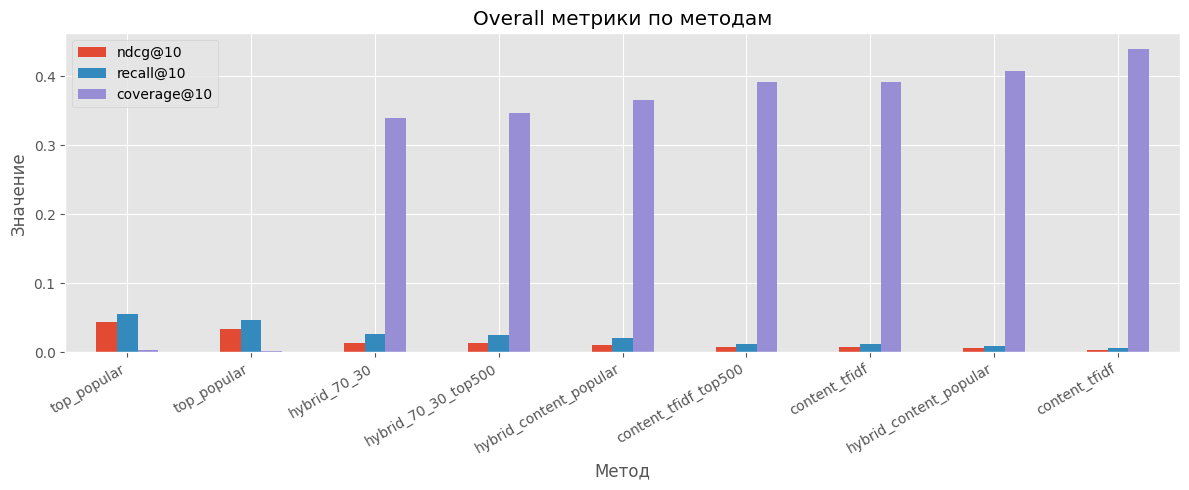

In [8]:
# Overall метрики
cols = [c for c in ['ndcg@10', 'recall@10', 'coverage@10'] if c in plot_df.columns]
ax = plot_df[cols].plot(kind='bar', figsize=(12, 5))
ax.set_title('Overall метрики по методам')
ax.set_ylabel('Значение')
ax.set_xlabel('Метод')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


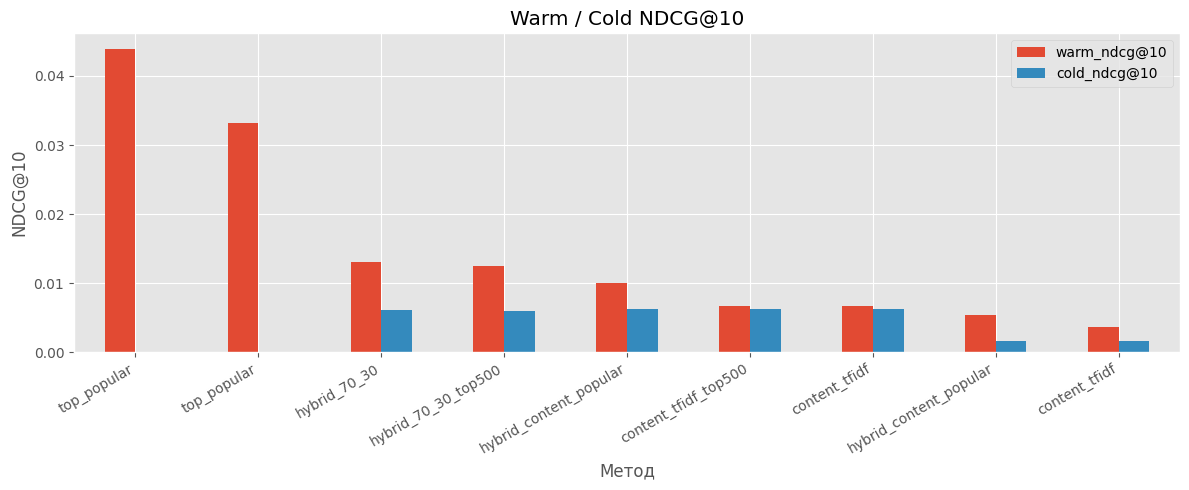

In [9]:
# Warm vs Cold NDCG
cols = [c for c in ['warm_ndcg@10', 'cold_ndcg@10'] if c in plot_df.columns]
ax = plot_df[cols].plot(kind='bar', figsize=(12, 5))
ax.set_title('Warm / Cold NDCG@10')
ax.set_ylabel('NDCG@10')
ax.set_xlabel('Метод')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


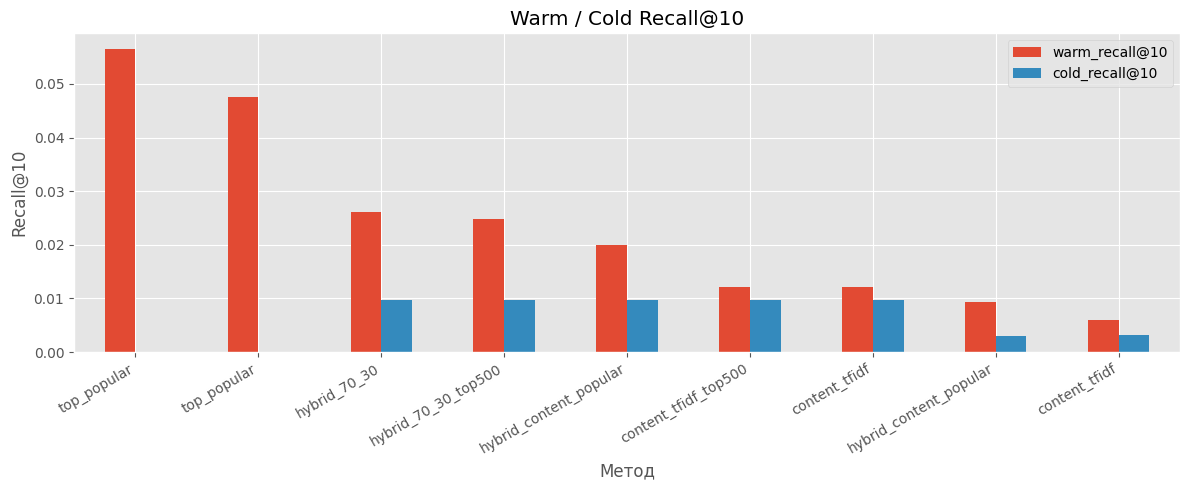

In [10]:
# Warm vs Cold Recall
cols = [c for c in ['warm_recall@10', 'cold_recall@10'] if c in plot_df.columns]
ax = plot_df[cols].plot(kind='bar', figsize=(12, 5))
ax.set_title('Warm / Cold Recall@10')
ax.set_ylabel('Recall@10')
ax.set_xlabel('Метод')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


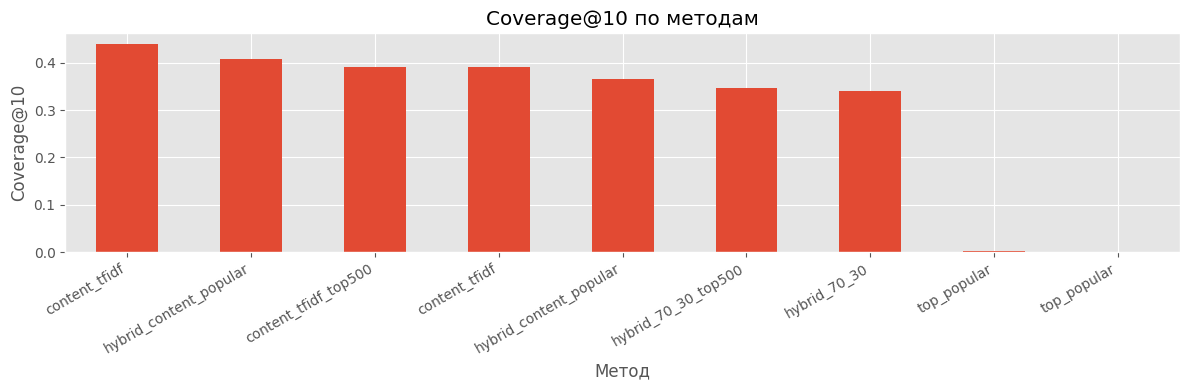

In [11]:
# Отдельно coverage для читаемости
if 'coverage@10' in plot_df.columns:
    ax = plot_df[['coverage@10']].sort_values('coverage@10', ascending=False).plot(kind='bar', figsize=(12, 4), legend=False)
    ax.set_title('Coverage@10 по методам')
    ax.set_ylabel('Coverage@10')
    ax.set_xlabel('Метод')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()
